In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL.Image as Image
import os
import math

In [2]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter


In [3]:
from model import Unet

In [5]:
class FocalLoss(torch.nn.Module):
    def __init__(self, gamma=2, alpha=1):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return torch.mean(focal_loss)

In [8]:
class SegData(Dataset):

    def __init__(self,image_paths,mask_paths,img_mean,img_std,transform = None):
        super().__init__()
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.img_mean = img_mean
        self.img_std = img_std

    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        
        image = Image.open(self.image_paths[index]).convert('RGB')
        mask = Image.open(self.mask_paths[index]).convert('L')

        image = np.array(image)
        mask = np.array(mask)

        image = np.transpose(image,(2,0,1))

        image = torch.from_numpy(image).to(torch.float32)
        mask = torch.from_numpy(mask).to(torch.long)

        image = torch.unsqueeze(image,0)
        mask = torch.unsqueeze(torch.unsqueeze(mask,dim=0),dim=0)
        
        basic_image_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (256,256)),
            transforms.Normalize(mean = self.img_mean,std = self.img_std),
        ])

        basic_mask_transform = transforms.Compose(transforms=[
            transforms.Resize(size = (256,256)),
            transforms.Lambda(lambda x: x/torch.max(x)),
        ])

        image = basic_image_transform(image)
        mask = basic_mask_transform(mask)

        image = image.squeeze()
        mask = mask.squeeze()

        if self.transform:

            image = self.transform(image)
            mask = self.transform(mask)
        
        sample = {'image':image,'mask':mask}

        return sample

In [9]:
data_dir = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'
data_fold = [x.name for x in os.scandir(data_dir) if x.is_dir()]
data_fold.remove('.ipynb_checkpoints')

total_input_files = []
total_output_files = []
for fold in data_fold:
    fold_dir = os.path.join(data_dir,fold)
    for subfold in [x.name for x in os.scandir(os.path.join(data_dir,fold)) if (x.is_dir and x.name[0]!='.' and x.name!='Thumbs.db')]:
        subfold_dir = os.path.join(fold_dir,subfold)
        if subfold == 'images':
            total_input_files.extend([os.path.join(subfold_dir,img_name) for img_name in os.listdir(os.path.join(fold_dir,subfold)) if img_name!='Thumbs.db'])
        elif subfold == 'masks':
            total_output_files.extend([os.path.join(subfold_dir,img_name) for img_name in os.listdir(os.path.join(fold_dir,subfold)) if img_name!='Thumbs.db'])

In [10]:
# h_img,w_img = Image.open(total_input_files[0]).convert('RGB').size
# #get normalization values for the complete dataset
# red_sum = 0
# # blue_sum = 0
# # green_sum = 0
# # because orignal data is grey scale so values are distributed evenly across all three channels.
# for files in total_input_files:

#     pil_image = Image.open(files).convert('RGB')
#     np_image = np.array(pil_image)

#     red_values = np_image[:,:,0].flatten()
#     # green_values = np_image[:,:,1].flatten()
#     # blue_values = np_image[:,:,2].flatten()

#     red_sum += np.sum(red_values)
#     # blue_sum += np.sum(blue_values)
#     # green_sum += np.sum(green_values)

#     del(red_values)
#     # del(green_values)
#     # del(blue_values)

# total_mean = [red_sum/(h_img*w_img*len(total_input_files))]*3

# red_std_sum = 0
# for files in total_input_files:

#     pil_image = Image.open(files).convert('RGB')
#     np_image = np.array(pil_image)

#     red_values = (np_image[:,:,0].flatten() - total_mean[0])**2
#     red_std_sum += np.sum(red_values)

#     del(red_values)

# total_std = [math.sqrt(red_std_sum/(h_img*w_img*len(total_input_files)))]*3

In [11]:
from tqdm import tqdm

In [12]:
import gc

In [13]:
def train():

    seed = 13
    torch.manual_seed(seed)
    best_v_loss = 1_000_000

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:1" if use_cuda else "cpu")
    
    model = Unet(3,1)
    model.to(device)
    epochs = 10
    loss_func = FocalLoss(gamma = 2, alpha = 1)
    loss_func.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer,factor = 0.8,min_lr=1e-6)
    pth = os.getcwd()
    model_path = os.path.join(pth,'model_2_focal')
    log_dir = os.path.join(model_path,'runs')
    wts_path = os.path.join(model_path,'weigths')

    if os.path.exists(model_path) == False:
        os.mkdir(model_path)
        
        os.mkdir(log_dir)
        
        os.mkdir(wts_path)
    
    writer = SummaryWriter(log_dir=log_dir)

    #splitting the dataset into traininig and validation set
    train_img,valid_img,train_mask,valid_mask = train_test_split(total_input_files,total_output_files,test_size=0.2,random_state=seed)
    train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    train_dataloader = DataLoader(train_data,batch_size = 4,shuffle = True,pin_memory = True)
    valid_dataloader = DataLoader(valid_data,batch_size = 4,shuffle = False,pin_memory = True)

    #print("After Model to device : ",torch.cuda.memory_allocated(device)/(1024*1024))
    for e in tqdm(range(epochs)):

        #training the model 
        print('Epoch {0}'.format(e+1))
        epoch_loss = 0.0
        run_loss = 0.0
        model.train(True)

        for i,batch in enumerate(train_dataloader):
            
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)
    
            #print(batch['image'].shape)
            v_img = transforms.RandomVerticalFlip(p=1)(image)
            h_img = transforms.RandomHorizontalFlip(p=1)(image)
            r_img = transforms.RandomRotation(degrees=(-25,25))(image)
            image_final = torch.cat((image,v_img,h_img,r_img),0)

            #print(image_final.shape)
                    
            v_mask = transforms.RandomVerticalFlip(p=1)(mask)
            h_mask = transforms.RandomHorizontalFlip(p=1)(mask)
            r_mask = transforms.RandomRotation(degrees=(-25,25))(mask)
            mask_final = torch.cat((mask,v_mask,h_mask,r_mask),0)
            mask_final = torch.unsqueeze(mask_final,1)
            #print(mask_final.shape)
            
#             image_final.to(device)
#             mask_final.to(device)
            
#             print(image_final.dtype)
#             print(mask_final.dtype)
#             print(device)
            #a = torch.cuda.memory_allocated(device)/(1024*1024)
            optimizer.zero_grad()
            pred = model.forward(image_final)
            #print("after forward pass", torch.cuda.memory_allocated(device)/(1024*1024))
            #b = torch.cuda.memory_allocated(device)/(1024*1024)
            #print("memory consumed by forward_pass",b-a)
            loss = loss_func(pred,mask_final)
            

            run_loss = run_loss + loss.item()
            epoch_loss = epoch_loss + loss.item()
            
            loss.backward()
            #print("memory after backward pass ", torch.cuda.memory_allocated(device)/(1024*1024))
            optimizer.step()
            #print("memory after optimizer ",torch.cuda.memory_allocated(device)/(1024*1024))

            #print('the current loss is {0}'.format(run_loss))
            
#             del mask_final
#             del image_final
#             del pred
#             del v_img
#             del h_img
#             del r_img
#             del v_mask
#             del h_mask
#             del r_mask
#             del mask
#             del image
            
            #print("memory after delete ",torch.cuda.memory_allocated(device)/(1024*1024))
            

            if(i%100 == 99):
                
#                 for obj in gc.get_objects():
#                     try:
#                         if torch.is_tensor(obj) or (hasattr(obj,'data') and torch.is_tensor(obg.data)):
#                             print(type(obj),obj.size())
#                     except:
#                         pass
                

                print("\tBatch Loss for curent for {0} is {1:.5f}".format(i,run_loss/100))
                run_loss = 0.0
                

        avg_e_loss = epoch_loss/(i+1)
        print('The average loss for the epoch is {0}'.format(avg_e_loss))

        #validating the model
        model.train(False)

        val_loss = 0.0

        for k,batch in enumerate(valid_dataloader):
            final_image = batch['image'].to(device)
            final_mask = torch.unsqueeze(batch['mask'],1).to(device)

            pred = model.forward(final_image)
            loss = loss_func(pred,final_mask)

            val_loss+= loss.item()
            
#             del final_image
#             del final_mask
#             break
        
        

        avg_val_loss = val_loss/(k+1)
        print('The average validation loss for the epoch is {0:.5f}'.format(avg_val_loss))
        writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_e_loss, 'Validation' : avg_val_loss },
                    e)
        
        if avg_val_loss < best_v_loss:

            best_v_loss = avg_val_loss
            best_wt_path = os.path.join(wts_path,'best_epoch'+str(e))
            

        writer.flush()
        

        #break
        wt_path =  os.path.join(wts_path,'epoch_'+str(e))
        torch.save(model.state_dict(), wt_path)
    torch.save(model.state_dict(), best_wt_path)

In [14]:
train()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
	Batch Loss for curent for 99 is 0.09932
	Batch Loss for curent for 199 is 0.06386
	Batch Loss for curent for 299 is 0.05647
	Batch Loss for curent for 399 is 0.04872
	Batch Loss for curent for 499 is 0.05220
	Batch Loss for curent for 599 is 0.04528
	Batch Loss for curent for 699 is 0.04488
	Batch Loss for curent for 799 is 0.03877
	Batch Loss for curent for 899 is 0.03708
	Batch Loss for curent for 999 is 0.03877
	Batch Loss for curent for 1099 is 0.03503
	Batch Loss for curent for 1199 is 0.03476
	Batch Loss for curent for 1299 is 0.03736
	Batch Loss for curent for 1399 is 0.03513
	Batch Loss for curent for 1499 is 0.03695
	Batch Loss for curent for 1599 is 0.03403
	Batch Loss for curent for 1699 is 0.03137
	Batch Loss for curent for 1799 is 0.02885
	Batch Loss for curent for 1899 is 0.02832
	Batch Loss for curent for 1999 is 0.03292
	Batch Loss for curent for 2099 is 0.02885
	Batch Loss for curent for 2199 is 0.02769
	Batch Loss for curent for 2299 is 0.02959
	Batch Loss fo

 10%|█         | 1/10 [30:36<4:35:24, 1836.02s/it]

Epoch 2
	Batch Loss for curent for 99 is 0.02181
	Batch Loss for curent for 199 is 0.02075
	Batch Loss for curent for 299 is 0.02204
	Batch Loss for curent for 399 is 0.02068
	Batch Loss for curent for 499 is 0.02222
	Batch Loss for curent for 599 is 0.02123
	Batch Loss for curent for 699 is 0.02138
	Batch Loss for curent for 799 is 0.02120
	Batch Loss for curent for 899 is 0.02365
	Batch Loss for curent for 999 is 0.02218
	Batch Loss for curent for 1099 is 0.02141
	Batch Loss for curent for 1199 is 0.02027
	Batch Loss for curent for 1299 is 0.02107
	Batch Loss for curent for 1399 is 0.02119
	Batch Loss for curent for 1499 is 0.02137
	Batch Loss for curent for 1599 is 0.02240
	Batch Loss for curent for 1699 is 0.01950
	Batch Loss for curent for 1799 is 0.02006
	Batch Loss for curent for 1899 is 0.02049
	Batch Loss for curent for 1999 is 0.01921
	Batch Loss for curent for 2099 is 0.02078
	Batch Loss for curent for 2199 is 0.01971
	Batch Loss for curent for 2299 is 0.02041
	Batch Loss fo

 20%|██        | 2/10 [1:01:15<4:05:05, 1838.18s/it]

Epoch 3
	Batch Loss for curent for 99 is 0.01873
	Batch Loss for curent for 199 is 0.01888
	Batch Loss for curent for 299 is 0.01854
	Batch Loss for curent for 399 is 0.01830
	Batch Loss for curent for 499 is 0.01801
	Batch Loss for curent for 599 is 0.01833
	Batch Loss for curent for 699 is 0.01851
	Batch Loss for curent for 799 is 0.01923
	Batch Loss for curent for 899 is 0.01963
	Batch Loss for curent for 999 is 0.01882
	Batch Loss for curent for 1099 is 0.01837
	Batch Loss for curent for 1199 is 0.01859
	Batch Loss for curent for 1299 is 0.01852
	Batch Loss for curent for 1399 is 0.01831
	Batch Loss for curent for 1499 is 0.01884
	Batch Loss for curent for 1599 is 0.01909
	Batch Loss for curent for 1699 is 0.01759
	Batch Loss for curent for 1799 is 0.01695
	Batch Loss for curent for 1899 is 0.01734
	Batch Loss for curent for 1999 is 0.01961
	Batch Loss for curent for 2099 is 0.01970
	Batch Loss for curent for 2199 is 0.01793
	Batch Loss for curent for 2299 is 0.01828
	Batch Loss fo

 30%|███       | 3/10 [1:31:59<3:34:46, 1840.94s/it]

Epoch 4
	Batch Loss for curent for 99 is 0.01699
	Batch Loss for curent for 199 is 0.01741
	Batch Loss for curent for 299 is 0.01692
	Batch Loss for curent for 399 is 0.01779
	Batch Loss for curent for 499 is 0.01803
	Batch Loss for curent for 599 is 0.01798
	Batch Loss for curent for 699 is 0.01742
	Batch Loss for curent for 799 is 0.01608
	Batch Loss for curent for 899 is 0.01626
	Batch Loss for curent for 999 is 0.01698
	Batch Loss for curent for 1099 is 0.01752
	Batch Loss for curent for 1199 is 0.01617
	Batch Loss for curent for 1299 is 0.01714
	Batch Loss for curent for 1399 is 0.01659
	Batch Loss for curent for 1499 is 0.01890
	Batch Loss for curent for 1599 is 0.01720
	Batch Loss for curent for 1699 is 0.01763
	Batch Loss for curent for 1799 is 0.01698
	Batch Loss for curent for 1899 is 0.01706
	Batch Loss for curent for 1999 is 0.01686
	Batch Loss for curent for 2099 is 0.01700
	Batch Loss for curent for 2199 is 0.01654
	Batch Loss for curent for 2299 is 0.01632
	Batch Loss fo

 40%|████      | 4/10 [2:02:40<3:04:04, 1840.81s/it]

Epoch 5
	Batch Loss for curent for 99 is 0.01697
	Batch Loss for curent for 199 is 0.01594
	Batch Loss for curent for 299 is 0.01533
	Batch Loss for curent for 399 is 0.01637
	Batch Loss for curent for 499 is 0.01623
	Batch Loss for curent for 599 is 0.01684
	Batch Loss for curent for 699 is 0.01645
	Batch Loss for curent for 799 is 0.01724
	Batch Loss for curent for 899 is 0.01562
	Batch Loss for curent for 999 is 0.01601
	Batch Loss for curent for 1099 is 0.01658
	Batch Loss for curent for 1199 is 0.01681
	Batch Loss for curent for 1299 is 0.01670
	Batch Loss for curent for 1399 is 0.01673
	Batch Loss for curent for 1499 is 0.01557
	Batch Loss for curent for 1599 is 0.01620
	Batch Loss for curent for 1699 is 0.01630
	Batch Loss for curent for 1799 is 0.01695
	Batch Loss for curent for 1899 is 0.01839
	Batch Loss for curent for 1999 is 0.01621
	Batch Loss for curent for 2099 is 0.01613
	Batch Loss for curent for 2199 is 0.01534
	Batch Loss for curent for 2299 is 0.01637
	Batch Loss fo

 50%|█████     | 5/10 [2:33:21<2:33:24, 1840.99s/it]

Epoch 6
	Batch Loss for curent for 99 is 0.01506
	Batch Loss for curent for 199 is 0.01663
	Batch Loss for curent for 299 is 0.01504
	Batch Loss for curent for 399 is 0.01587
	Batch Loss for curent for 499 is 0.01550
	Batch Loss for curent for 599 is 0.01533
	Batch Loss for curent for 699 is 0.01569
	Batch Loss for curent for 799 is 0.01585
	Batch Loss for curent for 899 is 0.01604
	Batch Loss for curent for 999 is 0.01614
	Batch Loss for curent for 1099 is 0.01562
	Batch Loss for curent for 1199 is 0.01555
	Batch Loss for curent for 1299 is 0.01578
	Batch Loss for curent for 1399 is 0.01552
	Batch Loss for curent for 1499 is 0.01591
	Batch Loss for curent for 1599 is 0.01663
	Batch Loss for curent for 1699 is 0.01497
	Batch Loss for curent for 1799 is 0.01533
	Batch Loss for curent for 1899 is 0.01578
	Batch Loss for curent for 1999 is 0.01567
	Batch Loss for curent for 2099 is 0.01482
	Batch Loss for curent for 2199 is 0.01623
	Batch Loss for curent for 2299 is 0.01599
	Batch Loss fo

 60%|██████    | 6/10 [3:04:03<2:02:45, 1841.30s/it]

Epoch 7
	Batch Loss for curent for 99 is 0.01581
	Batch Loss for curent for 199 is 0.01587
	Batch Loss for curent for 299 is 0.01523
	Batch Loss for curent for 399 is 0.01621
	Batch Loss for curent for 499 is 0.01545
	Batch Loss for curent for 599 is 0.01580
	Batch Loss for curent for 699 is 0.01506
	Batch Loss for curent for 799 is 0.01476
	Batch Loss for curent for 899 is 0.01500
	Batch Loss for curent for 999 is 0.01458
	Batch Loss for curent for 1099 is 0.01510
	Batch Loss for curent for 1199 is 0.01549
	Batch Loss for curent for 1299 is 0.01463
	Batch Loss for curent for 1399 is 0.01457
	Batch Loss for curent for 1499 is 0.01460
	Batch Loss for curent for 1599 is 0.01548
	Batch Loss for curent for 1699 is 0.01598
	Batch Loss for curent for 1799 is 0.01497
	Batch Loss for curent for 1899 is 0.01548
	Batch Loss for curent for 1999 is 0.01548
	Batch Loss for curent for 2099 is 0.01476
	Batch Loss for curent for 2199 is 0.01554
	Batch Loss for curent for 2299 is 0.01498
	Batch Loss fo

 70%|███████   | 7/10 [3:34:49<1:32:08, 1842.81s/it]

Epoch 8
	Batch Loss for curent for 99 is 0.01484
	Batch Loss for curent for 199 is 0.01501
	Batch Loss for curent for 299 is 0.01512
	Batch Loss for curent for 399 is 0.01488
	Batch Loss for curent for 499 is 0.01435
	Batch Loss for curent for 599 is 0.01479
	Batch Loss for curent for 699 is 0.01466
	Batch Loss for curent for 799 is 0.01554
	Batch Loss for curent for 899 is 0.01582
	Batch Loss for curent for 999 is 0.01485
	Batch Loss for curent for 1099 is 0.01478
	Batch Loss for curent for 1199 is 0.01467
	Batch Loss for curent for 1299 is 0.01449
	Batch Loss for curent for 1399 is 0.01463
	Batch Loss for curent for 1499 is 0.01493
	Batch Loss for curent for 1599 is 0.01600
	Batch Loss for curent for 1699 is 0.01528
	Batch Loss for curent for 1799 is 0.01540
	Batch Loss for curent for 1899 is 0.01431
	Batch Loss for curent for 1999 is 0.01507
	Batch Loss for curent for 2099 is 0.01522
	Batch Loss for curent for 2199 is 0.01534
	Batch Loss for curent for 2299 is 0.01462
	Batch Loss fo

 80%|████████  | 8/10 [4:05:32<1:01:25, 1842.74s/it]

Epoch 9
	Batch Loss for curent for 99 is 0.01552
	Batch Loss for curent for 199 is 0.01420
	Batch Loss for curent for 299 is 0.01434
	Batch Loss for curent for 399 is 0.01522
	Batch Loss for curent for 499 is 0.01498
	Batch Loss for curent for 599 is 0.01446
	Batch Loss for curent for 699 is 0.01496
	Batch Loss for curent for 799 is 0.01411
	Batch Loss for curent for 899 is 0.01492
	Batch Loss for curent for 999 is 0.01501
	Batch Loss for curent for 1099 is 0.01457
	Batch Loss for curent for 1199 is 0.01477
	Batch Loss for curent for 1299 is 0.01502
	Batch Loss for curent for 1399 is 0.01486
	Batch Loss for curent for 1499 is 0.01510
	Batch Loss for curent for 1599 is 0.01436
	Batch Loss for curent for 1699 is 0.01459
	Batch Loss for curent for 1799 is 0.01498
	Batch Loss for curent for 1899 is 0.01551
	Batch Loss for curent for 1999 is 0.01431
	Batch Loss for curent for 2099 is 0.01533
	Batch Loss for curent for 2199 is 0.01454
	Batch Loss for curent for 2299 is 0.01459
	Batch Loss fo

 90%|█████████ | 9/10 [4:36:15<30:42, 1842.80s/it]  

Epoch 10
	Batch Loss for curent for 99 is 0.01511
	Batch Loss for curent for 199 is 0.01469
	Batch Loss for curent for 299 is 0.01456
	Batch Loss for curent for 399 is 0.01451
	Batch Loss for curent for 499 is 0.01538
	Batch Loss for curent for 599 is 0.01456
	Batch Loss for curent for 699 is 0.01422
	Batch Loss for curent for 799 is 0.01389
	Batch Loss for curent for 899 is 0.01432
	Batch Loss for curent for 999 is 0.01466
	Batch Loss for curent for 1099 is 0.01480
	Batch Loss for curent for 1199 is 0.01467
	Batch Loss for curent for 1299 is 0.01469
	Batch Loss for curent for 1399 is 0.01460
	Batch Loss for curent for 1499 is 0.01505
	Batch Loss for curent for 1599 is 0.01516
	Batch Loss for curent for 1699 is 0.01356
	Batch Loss for curent for 1799 is 0.01458
	Batch Loss for curent for 1899 is 0.01477
	Batch Loss for curent for 1999 is 0.01525
	Batch Loss for curent for 2099 is 0.01563
	Batch Loss for curent for 2199 is 0.01405
	Batch Loss for curent for 2299 is 0.01385
	Batch Loss f

100%|██████████| 10/10 [5:06:47<00:00, 1840.74s/it]


In [15]:
torch.cuda.empty_cache()

In [21]:
def diceScore(inputs, targets):
    # Calculate intersection and union for each sample in the batch
    epsilon = 1e-6
    intersection = torch.sum(inputs * targets, dim=(1, 2, 3))  # Sum over height, width, and channels
    total = torch.sum(inputs, dim=(1, 2, 3)) + torch.sum(targets, dim=(1, 2, 3))

    # Calculate Dice coefficient with epsilon for numerical stability
    dice_coefficient = (2. * intersection + epsilon) / (total + epsilon)

    return torch.mean(dice_coefficient)

In [22]:
def validate():
    # visualize the mask outputs
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:1" if use_cuda else "cpu")
    train_img,valid_img,train_mask,valid_mask = train_test_split(total_input_files,total_output_files,test_size=0.2,random_state=13)
    #     train_data = SegData(image_paths = train_img,mask_paths=train_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    valid_data = SegData(image_paths = valid_img,mask_paths=valid_mask,img_mean=[129.908, 129.908, 129.908],img_std=[64.484, 64.484, 64.484])
    model_vis = Unet(3,1)
    model_vis_path = '/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/UNET/model_2_focal/weigths/best_epoch7'
    model_vis.load_state_dict(torch.load(model_vis_path))
    model_vis.to(device)
    model_vis.eval()
    dice_scores = []

    test_dataloader = DataLoader(valid_data,batch_size = 1,shuffle = True,pin_memory = True)
    threshold = 0.5
    for k,batch in enumerate(test_dataloader):
        final_image = batch['image'].to(device)
        final_mask = torch.unsqueeze(batch['mask'],1)

        pred = model_vis.forward(final_image)
        pred = torch.sigmoid(pred).cpu().detach()
        pred_score = torch.where(pred>0.5,torch.tensor(1),torch.tensor(0))
        dice_score = diceScore(pred_score,final_mask)
        dice_scores.append(dice_score.item())

    print('The average dice score is {0}'.format(np.mean(np.array(dice_scores))))
    
    final_image_show = torch.squeeze(final_image).cpu().detach().numpy()
    final_image_transpose = np.transpose(final_image_show,(1,2,0))

    final_mask_transpose = torch.squeeze(final_mask).cpu().detach().numpy()

    pred_image_transpose = torch.squeeze(pred).cpu().detach().numpy()

    bin_image_transpose = torch.squeeze(pred_score).cpu().detach().numpy()


    plt.figure(figsize = (12,4))
    plt.subplot(2,4,1)
    plt.imshow(final_image_transpose)
    plt.title('orignal image')

    plt.figure(figsize = (12,4))
    plt.subplot(2,4,2)
    plt.imshow(final_mask_transpose,cmap = 'gray')
    plt.title('orignal mask')

    plt.figure(figsize = (12,4))
    plt.subplot(2,4,3)
    plt.imshow(pred_image_transpose,cmap = 'jet',vmin = 0, vmax = 1)
    plt.title('pred map')

    plt.figure(figsize = (12,4))
    plt.subplot(2,4,4)
    plt.imshow(bin_image_transpose,cmap = 'gray')
    plt.title('binary output')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The average dice score is 0.9857488199805102


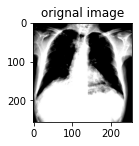

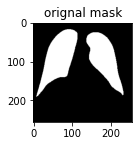

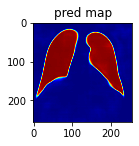

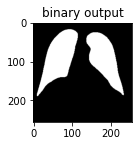

In [23]:
validate()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir='/home/UFAD/s.kapoor/GrainGrowth/skapoor/dl_mis/COVID-19_Radiography_Dataset/UNET/model_focal_loss/runs'

In [16]:
total_mean

[129.90850553548862, 129.90850553548862, 129.90850553548862]

In [17]:
total_std

[64.48403222822402, 64.48403222822402, 64.48403222822402]

In [13]:
import pytorch_model_summary as pms

In [14]:
model = Unet(3,1)

In [16]:
print(pms.summary(model, torch.zeros((32, 3, 256, 256)), show_input=True, show_hierarchical=True))

-------------------------------------------------------------------------------------------------
       Layer (type)                                  Input Shape         Param #     Tr. Param #
       DoubleConv-1                            [32, 3, 256, 256]          38,976          38,976
       DownSample-2                           [32, 64, 256, 256]               0               0
       DoubleConv-3                           [32, 64, 128, 128]         221,952         221,952
       DownSample-4                          [32, 128, 128, 128]               0               0
       DoubleConv-5                            [32, 128, 64, 64]         886,272         886,272
       DownSample-6                            [32, 256, 64, 64]               0               0
       DoubleConv-7                            [32, 256, 32, 32]       3,542,016       3,542,016
       DownSample-8                            [32, 512, 32, 32]               0               0
       DoubleConv-9          